In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')


In [17]:
train_dir = "./train-subset"
test_dir = "./test-subset"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 5
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

In [18]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [19]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                   )
test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 9884 images belonging to 14 classes.
Found 4303 images belonging to 14 classes.


In [20]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(train_generator.classes).count(i) for i in np.unique(train_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [21]:
fig = px.bar(x = CLASS_LABELS,
             y = [list(test_generator.classes).count(i) for i in np.unique(test_generator.classes)] , 
             color = np.unique(train_generator.classes) ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Test Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [22]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3),
                                               include_top=False,
                                               weights="imagenet")(inputs)
    
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4) (x)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
    
    return x

    
def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    
    return classification_output

def define_compile_model():
    
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT ,IMG_WIDTH,3))
    classification_output = final_model(inputs) 
    model = tf.keras.Model(inputs=inputs, outputs = classification_output)
     
    model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])
  
    return model

model = define_compile_model()
clear_output()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 14)             │         7,182 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,095,054 (30.88 MB)

 Trainable params: 8,011,406 (30.56 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [23]:
history = model.fit(x = train_generator,validation_data=test_generator,epochs = EPOCHS)

Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 1527s 10s/step - auc_2: 0.4933 - loss: 3.2211 - val_auc_2: 0.4894 - val_loss: 3.3218
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 61668s 400s/step - auc_2: 0.4948 - loss: 3.1865 - val_auc_2: 0.4854 - val_loss: 3.6386
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - auc_2: 0.5033 - loss: 3.1516 - val_auc_2: 0.4678 - val_loss: 3.1851
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - auc_2: 0.5003 - loss: 3.1555 - val_auc_2: 0.5005 - val_loss: 2.7409
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - auc_2: 0.5089 - loss: 3.0955 - val_auc_2: 0.4943 - val_loss: 2.6858


In [24]:
# import tensorflow as tf
# import numpy as np
# from collections import defaultdict

# # Define a function to create a subset generator with 100 images per class
# def subset_generator(data_generator, num_images_per_class=100):
#     """
#     Extracts a fixed number of images per class from an ImageDataGenerator.
    
#     Parameters:
#     - data_generator: The original ImageDataGenerator instance.
#     - num_images_per_class: Number of images to extract per class.

#     Returns:
#     - A new generator yielding a subset of the original dataset.
#     """
#     class_counts = defaultdict(int)
#     subset_images = []
#     subset_labels = []
    
#     for images, labels in data_generator:
#         for i in range(len(images)):
#             # Get category index
#             class_idx = np.argmax(labels[i])
#             class_name = list(data_generator.class_indices.keys())[class_idx]

#             # Store images if not exceeded the limit
#             if class_counts[class_name] < num_images_per_class:
#                 subset_images.append(images[i])
#                 subset_labels.append(labels[i])
#                 class_counts[class_name] += 1

#         # Stop when all categories have enough images
#         if all(count >= num_images_per_class for count in class_counts.values()):
#             break  

#     # Convert to numpy arrays
#     subset_images = np.array(subset_images)
#     subset_labels = np.array(subset_labels)
    
#     # Create a new generator using ImageDataGenerator.flow()
#     subset_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
#     subset_generator = subset_datagen.flow(subset_images, subset_labels, batch_size=BATCH_SIZE, shuffle=True)

#     return subset_generator

# # Load only 100 images per class
# train_subset = subset_generator(train_generator, num_images_per_class=100)
# test_subset = subset_generator(test_generator, num_images_per_class=100)

# # Feature Extractor
# def feature_extractor(inputs):
#     feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#                                                            include_top=False,
#                                                            weights="imagenet")(inputs)
#     return feature_extractor

# # Classifier
# def classifier(inputs):
#     x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
#     x = tf.keras.layers.Dense(256, activation="relu")(x)
#     x = tf.keras.layers.Dropout(0.3)(x)
#     x = tf.keras.layers.Dense(1024, activation="relu")(x)
#     x = tf.keras.layers.Dropout(0.5)(x)
#     x = tf.keras.layers.Dense(512, activation="relu")(x)
#     x = tf.keras.layers.Dropout(0.4)(x)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="classification")(x)
#     return x

# # Final Model
# def final_model(inputs):
#     densenet_feature_extractor = feature_extractor(inputs)
#     classification_output = classifier(densenet_feature_extractor)
#     return classification_output

# # Define & Compile Model
# def define_compile_model():
#     inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
#     classification_output = final_model(inputs)
#     model = tf.keras.Model(inputs=inputs, outputs=classification_output)
    
#     model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=LR), 
#                   loss='categorical_crossentropy',
#                   metrics=[tf.keras.metrics.AUC()])
    
#     return model

# # Initialize Model



In [25]:
# model = define_compile_model()
# model.summary()



In [26]:
# Train using the subset
# history = model.fit(x=train_subset, validation_data=test_subset, epochs=EPOCHS)

In [27]:
model.save('my_model.h5')

68/68 ━━━━━━━━━━━━━━━━━━━━ 53s 684ms/step
ROC AUC score: 0.4937792452010978


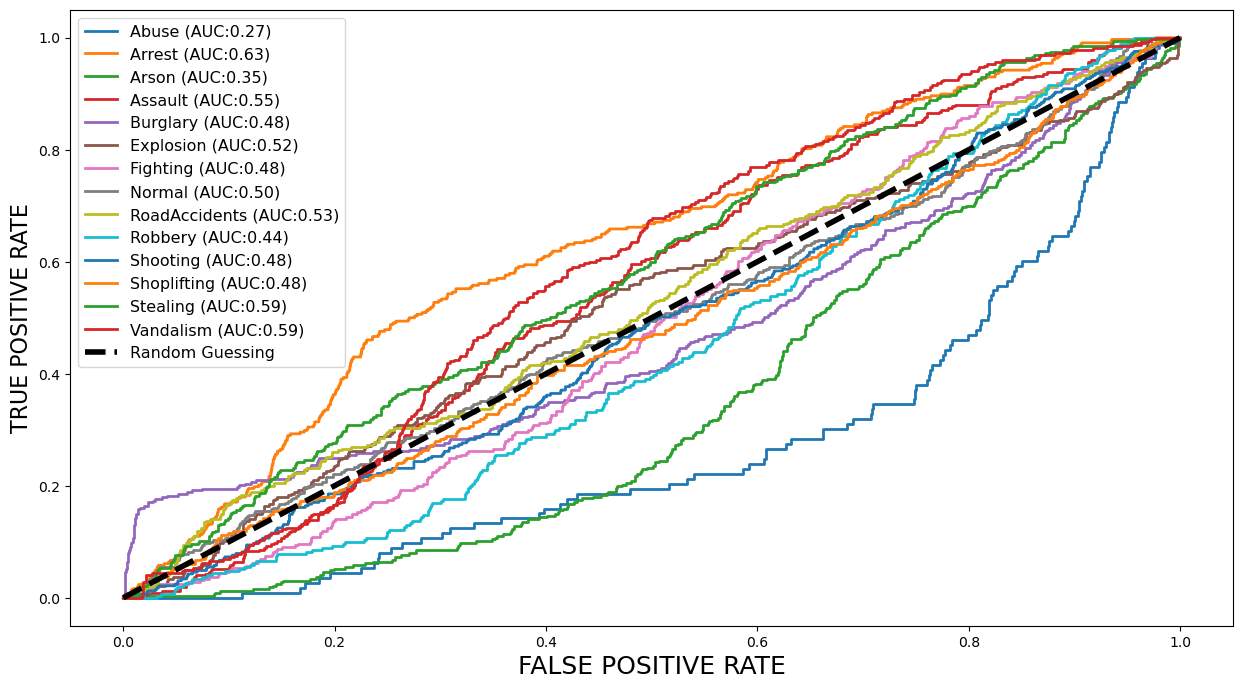

In [28]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)

plt.legend(fontsize = 11.5)
plt.show()

In [29]:
# model